# <font color='blue'>**RVM**</font> 

Сегодня мы увидим битву двух ML-машин

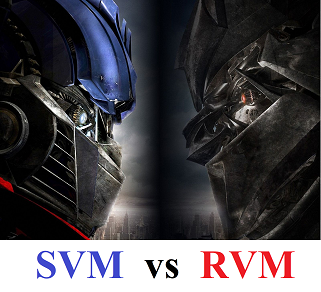

Проведём эксперимент из оригинальной статьи про RVR

Tipping, Michael E. (2001). "Sparse Bayesian Learning and the Relevance Vector Machine". Journal of Machine Learning Research. 1: 211–244 https://www.jmlr.org/papers/volume1/tipping01a/tipping01a.pdf

# <font color='green'>0. Импорт необходимых модулей</font>  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Импортируем time, чтобы сравнивать время работы моделей

In [ ]:
import time

Зафиксируем стейт для генерации данных

In [ ]:
np.random.seed(42)
rng = np.random.RandomState(0)

# <font color='green'>1. Сэмплируем из sinc </font>

Введём функцию 

$${\displaystyle \operatorname {sinc} x={\frac {\sin (\pi x)}{\pi x}}.}$$

Эта функция возникает при обработке сигналов (в Речи) как преобразование Фурье от прямоугольной функции на отрезке $[-\frac{1}{2}, \frac{1}{2}]$.

В качестве данных возьмём точки на кривой $$y = \operatorname{sinc}(x)$$ и прибавим к ним случайный шум.

In [ ]:
X = 4 * np.pi * np.random.random(100) - 2 * np.pi
y = np.sinc(X)
y += 0.25 * (0.5 - rng.rand(X.shape[0]))  # add noise

Посмотрим на данные 

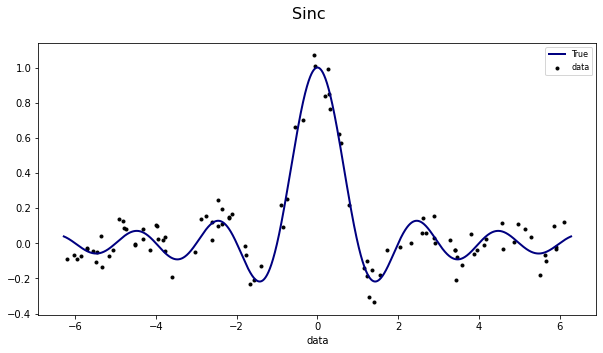

In [ ]:
# По оси х берём 10'000 точек в (-2 pi, 2 pi) 
X_plot = np.linspace(-2 * np.pi, 2 * np.pi, 10000)[:, None]

# Plot results
fig = plt.figure(figsize=(10, 5))
lw = 2
fig.suptitle("Sinc", fontsize=16)

plt.scatter(X, y, marker=".", c="k", label="data")
plt.plot(X_plot, np.sinc(X_plot), color="navy", lw=lw, label="True")

plt.xlabel("data")
plt.legend(loc="best", scatterpoints=1, prop={"size": 8})
plt.show()

# <font color='green'>2. SVM </font>

Дока https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [ ]:
from sklearn.svm import SVR

Возьмём популярное rbf-ядро $$\exp(-\gamma \|x-x'\|^2)$$

In [ ]:
svr = SVR(kernel="rbf", gamma="auto")

Измерим время выполнения

In [ ]:
stime = time.time()
X = X[:, None] # X.shape = (N, 1)
svr.fit(X, y)
print("Time for SVR fitting: %.3f" % (time.time() - stime))

Time for SVR fitting: 0.003


Предсказание для SVR

In [ ]:
stime = time.time()
y_svr = svr.predict(X_plot)
print("Time for SVR prediction: %.3f" % (time.time() - stime))

Time for SVR prediction: 0.025


# <font color='green'>3. RVM </font>

RVM не реализован в sklearn, воспользуемся https://sklearn-rvm.readthedocs.io/en/latest/index.html

In [ ]:
pip install -U sklearn-rvm

In [ ]:
from sklearn_rvm import EMRVR

Интерфейс похож на SVM

In [ ]:
# Fit RVR
rvr = EMRVR(kernel="rbf", gamma='auto')

Обучается RVM <font color='red'> подольше </font>  SVR

In [ ]:
stime = time.time()
rvr.fit(X, y)
print("Time for RVR fitting: %.3f" % (time.time() - stime))

Time for RVR fitting: 0.741


Предсказывает RVM <font color='blue'> быстрее </font> SVM

In [ ]:
# Predict using Rvm
stime = time.time()
y_rvr = rvr.predict(X_plot, return_std=False)
print("Time for RVR prediction: %.3f" % (time.time() - stime))

Time for RVR prediction: 0.012


RVM может предсказывать стандартное отклонение **return_std=True** (хотя на это и требуется дополнительное время)

In [ ]:
stime = time.time()
y_rvr, y_std = rvr.predict(X_plot, return_std=True)
print("Time for RVR prediction with standard-deviation: %.3f" % (time.time() - stime))

Time for RVR prediction with standard-deviation: 0.444


# <font color='green'>4. Графики </font>

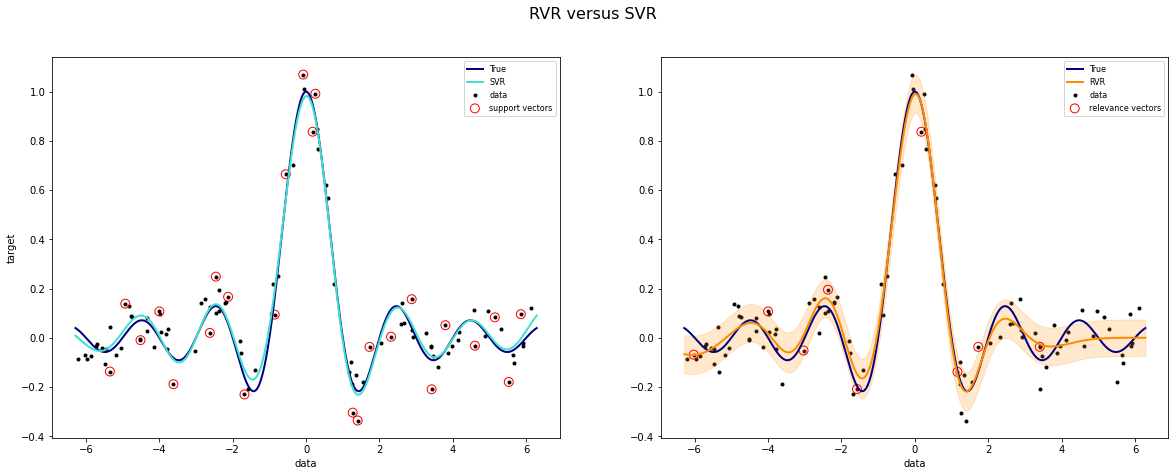

In [ ]:
# Plot results
fig = plt.figure(figsize=(20, 7))
lw = 2
fig.suptitle("RVR versus SVR", fontsize=16)

plt.subplot(121)
plt.scatter(X, y, marker=".", c="k", label="data")
plt.plot(X_plot, np.sinc(X_plot), color="navy", lw=lw, label="True")

plt.plot(X_plot, y_svr, color="turquoise", lw=lw, label="SVR")
support_vectors_idx = svr.support_
plt.scatter(X[support_vectors_idx], y[support_vectors_idx], s=80, facecolors="none", edgecolors="r",
            label="support vectors")
plt.ylabel("target")
plt.xlabel("data")
plt.legend(loc="best", scatterpoints=1, prop={"size": 8})

plt.subplot(122)
plt.scatter(X, y, marker=".", c="k", label="data")
plt.plot(X_plot, np.sinc(X_plot), color="navy", lw=lw, label="True")

plt.plot(X_plot, y_rvr, color="darkorange", lw=lw, label="RVR")
plt.fill_between(X_plot[:, 0], y_rvr - y_std, y_rvr + y_std, color="darkorange", alpha=0.2)
relevance_vectors_idx = rvr.relevance_
plt.scatter(X[relevance_vectors_idx], y[relevance_vectors_idx], s=80, facecolors="none", edgecolors="r",
            label="relevance vectors")

plt.xlabel("data")
plt.legend(loc="best", scatterpoints=1, prop={"size": 8})
plt.show()